In [57]:
import pandas as pd
#import italy covid cases
df_covid_cases = pd.read_csv('https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-province/dpc-covid19-ita-province.csv',delimiter=',', keep_default_na=False, na_values=[''])
print(df_covid_cases.head())
#import environmental air quality data
df_air_data = pd.read_csv('../datasets/waqi-covid19-airqualitydata-2020.csv',delimiter=',', keep_default_na=False, na_values=[''])
print(df_air_data.head())
# import movements percentage
df_moves = pd.read_csv('../datasets/Global_Mobility_Report.csv',delimiter=',', keep_default_na=False, na_values=[''], dtype='unicode')
print(df_moves.head())

                  data stato  codice_regione denominazione_regione  \
0  2020-02-24T18:00:00   ITA              13               Abruzzo   
1  2020-02-24T18:00:00   ITA              13               Abruzzo   
2  2020-02-24T18:00:00   ITA              13               Abruzzo   
3  2020-02-24T18:00:00   ITA              13               Abruzzo   
4  2020-02-24T18:00:00   ITA              13               Abruzzo   

   codice_provincia               denominazione_provincia sigla_provincia  \
0                66                              L'Aquila              AQ   
1                67                                Teramo              TE   
2                68                               Pescara              PE   
3                69                                Chieti              CH   
4               979  In fase di definizione/aggiornamento             NaN   

         lat       long  totale_casi note  
0  42.351222  13.398438            0  NaN  
1  42.658918  13.704400     

In [58]:
#Global Mobility ops
#df_moves.head()
#filter on Italy
df_moves = df_moves.loc[df_moves['country_region_code'] == 'IT']
#filter on metropolitan cities
df_moves = df_moves.loc[df_moves['sub_region_2'].isin(['Metropolitan City of Bari','Metropolitan City of Bologna','Metropolitan City of Cagliari',
                                                       'Metropolitan City of Florence','Metropolitan City of Genoa','Metropolitan City of Milan',
                                                       'Metropolitan City of Naples','Metropolitan City of Rome','Metropolitan City of Turin',
                                                       'Metropolitan City of Venice'])]
#drops useless colums
#df_moves=df_moves.drop(df_moves.columns['metro_area', 'iso_3166_2_code','census_fips_code'], axis='columns')
df_moves = df_moves.drop(['metro_area', 'iso_3166_2_code','census_fips_code',
                          'country_region_code','country_region','sub_region_1'],axis=1) 
#change name of cities
df_moves.loc[df_moves['sub_region_2'] == 'Metropolitan City of Bari', 'sub_region_2'] = 'Bari'
df_moves.loc[df_moves['sub_region_2'] == 'Metropolitan City of Bologna', 'sub_region_2'] = 'Bologna'
df_moves.loc[df_moves['sub_region_2'] == 'Metropolitan City of Cagliari', 'sub_region_2'] = 'Cagliari'
df_moves.loc[df_moves['sub_region_2'] == 'Metropolitan City of Florence', 'sub_region_2'] = 'Firenze'
df_moves.loc[df_moves['sub_region_2'] == 'Metropolitan City of Genoa', 'sub_region_2'] = 'Genova'
df_moves.loc[df_moves['sub_region_2'] == 'Metropolitan City of Milan', 'sub_region_2'] = 'Milano'
df_moves.loc[df_moves['sub_region_2'] == 'Metropolitan City of Naples', 'sub_region_2'] = 'Napoli'
df_moves.loc[df_moves['sub_region_2'] == 'Metropolitan City of Rome', 'sub_region_2'] = 'Roma'
df_moves.loc[df_moves['sub_region_2'] == 'Metropolitan City of Turin', 'sub_region_2'] = 'Torino'
df_moves.loc[df_moves['sub_region_2'] == 'Metropolitan City of Venice', 'sub_region_2'] = 'Venezia'

#cast date on datetime
df_moves['date'] = pd.to_datetime(df_moves['date'], format="%Y-%m-%d")
df_moves.dtypes
df_moves_final = pd.DataFrame(columns=['sub_region_2', 'retail_and_recreation', 'grocery_and_pharmacy','parks','transit_stations',
                                       'workplaces','residential','date','MoveIndex'])
# adding daily movements per metropolitan city
cities_moves = df_moves.groupby(['sub_region_2']).count().index
for c in cities_moves:
    print(c)
     # filter dataframe by city
    df_moves_c = df_moves.loc[df_moves['sub_region_2'] == c]
    # order by Date
    df_moves_c = df_moves_c.sort_values(by=['date'])
    #check if any missing values in all columns
    null_columns=df_moves_c.columns[df_moves_c.isnull().any()]
    if null_columns.empty:
        print('All columns fitted')
    else: 
        print('Null values in ')
        print(df_moves_c[null_columns].isnull().sum())
    #print(df_moves_c.head())
    #check if any missing date attribute
    df_moves_c.set_index('date',inplace=True)
    df_moves_c=df_moves_c.resample('D').agg({'sub_region_2':'max','retail_and_recreation':'max','grocery_and_pharmacy':'max','parks':'max',
                                            'transit_stations':'max','workplaces':'max','residential':'max'})
    #print(df_moves_c.head())
    #check if any null values
    null_columns=df_moves_c.columns[df_moves_c.isnull().any()]
    if null_columns.empty:
        print('All dates fitted')
    else: 
        print('Null dates values in ')
        print(df_moves_c[null_columns].isnull().sum())
    
    # casting
    df_moves_c['date'] = df_moves_c.index
    df_moves_c['date'] = pd.to_datetime(df_moves_c['date'])
    df_moves_c = df_moves_c.astype({'retail_and_recreation': 'int32','grocery_and_pharmacy': 'int32',
                                   'parks': 'int32','transit_stations': 'int32','workplaces': 'int32','residential': 'int32'})
    #print(df_moves_c.dtypes)
    df_moves_c.reset_index(drop=True, inplace=True)
    print('period of time:')
    print(df_moves_c['date'].min())
    print(df_moves_c['date'].max())
    # compute MoveIndex
    # It is not considering 'residential'
    df_moves_c['MoveIndex'] =  df_moves_c['retail_and_recreation'] + df_moves_c['grocery_and_pharmacy'] + df_moves_c['parks'] + df_moves_c['transit_stations'] + df_moves_c['workplaces']
    #print(df_moves_c.head())
    frames = [df_moves_final, df_moves_c]
    result = pd.concat(frames)
    df_moves_final = result
    
df_moves_final.head()

Bari
All columns fitted
All dates fitted
period of time:
2020-02-15 00:00:00
2020-08-21 00:00:00
Bologna
All columns fitted
All dates fitted
period of time:
2020-02-15 00:00:00
2020-08-21 00:00:00
Cagliari
All columns fitted
All dates fitted
period of time:
2020-02-15 00:00:00
2020-08-21 00:00:00
Firenze
All columns fitted
All dates fitted
period of time:
2020-02-15 00:00:00
2020-08-21 00:00:00
Genova
All columns fitted
All dates fitted
period of time:
2020-02-15 00:00:00
2020-08-21 00:00:00
Milano
All columns fitted
All dates fitted
period of time:
2020-02-15 00:00:00
2020-08-21 00:00:00
Napoli
All columns fitted
All dates fitted
period of time:
2020-02-15 00:00:00
2020-08-21 00:00:00
Roma
All columns fitted
All dates fitted
period of time:
2020-02-15 00:00:00
2020-08-21 00:00:00
Torino
All columns fitted
All dates fitted
period of time:
2020-02-15 00:00:00
2020-08-21 00:00:00
Venezia
All columns fitted
All dates fitted
period of time:
2020-02-15 00:00:00
2020-08-21 00:00:00


,sub_region_2,retail_and_recreation,grocery_and_pharmacy,parks,transit_stations,workplaces,residential,date,MoveIndex
0,Bari,-2,-2,8,1,-1,0,2020-02-15,4
1,Bari,4,-10,80,12,-2,-2,2020-02-16,84
2,Bari,-1,-3,10,4,1,0,2020-02-17,11
3,Bari,0,-2,15,3,0,0,2020-02-18,16
4,Bari,-5,-4,3,3,0,0,2020-02-19,-3


C:\Users\r.palmieri\AppData\Roaming\Python\Python37\site-packages\pandas\core\generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


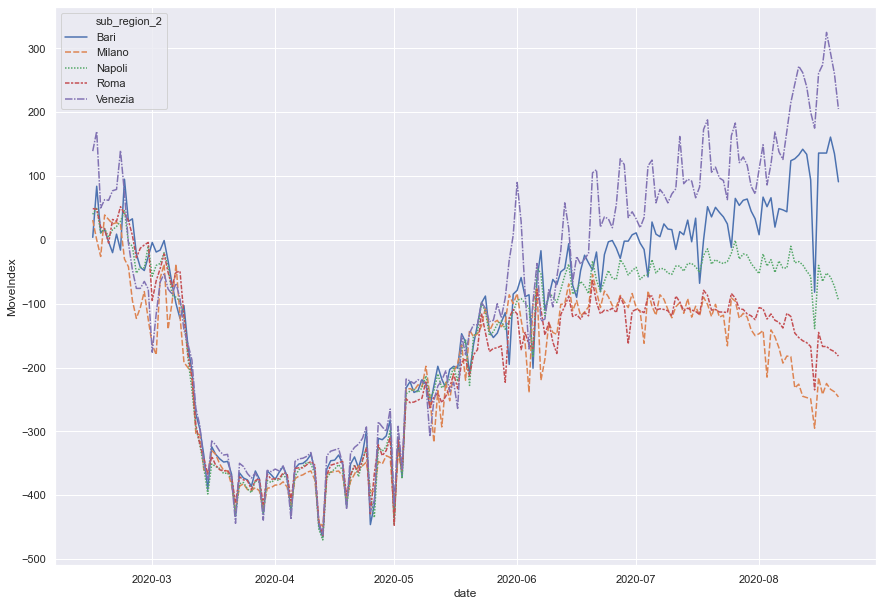

In [59]:
#Plot MoveIndex
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
sns.set(rc={'figure.figsize':(14.7,10.27)})
df_moves_final = df_moves_final.loc[df_moves_final['sub_region_2'].isin(['Venezia','Milano','Roma','Napoli','Bari'])]
df_moves_final.MoveIndex = df_moves_final.MoveIndex.astype(float)
df_moves_final.residential = df_moves_final.residential.astype(float)
ax = sns.lineplot(x="date", y="MoveIndex", hue="sub_region_2", style="sub_region_2",
                  data=df_moves_final)

In [60]:
#Covd Ops
# cast operation
df_covid_cases.dtypes
df_covid_cases['data'] = pd.to_datetime(df_covid_cases['data'], format="%Y-%m-%dT%H:%M:%S")
df_covid_cases['data'] = df_covid_cases['data'].dt.date
print(df_covid_cases.head())
print(df_air_data.dtypes)
df_air_data['Date'] = pd.to_datetime(df_air_data['Date'], format="%Y-%m-%d")
# print(df_air_data.dtypes)
# print(df_air_data.head())

         data stato  codice_regione denominazione_regione  codice_provincia  \
0  2020-02-24   ITA              13               Abruzzo                66   
1  2020-02-24   ITA              13               Abruzzo                67   
2  2020-02-24   ITA              13               Abruzzo                68   
3  2020-02-24   ITA              13               Abruzzo                69   
4  2020-02-24   ITA              13               Abruzzo               979   

                denominazione_provincia sigla_provincia        lat       long  \
0                              L'Aquila              AQ  42.351222  13.398438   
1                                Teramo              TE  42.658918  13.704400   
2                               Pescara              PE  42.464584  14.213648   
3                                Chieti              CH  42.351032  14.167546   
4  In fase di definizione/aggiornamento             NaN        NaN        NaN   

   totale_casi note  
0            0  

In [61]:
# adding daily cases per city
cities_covid = df_covid_cases.groupby(['denominazione_provincia']).count().index
print(cities_covid)
df_covid_cases_ext = pd.DataFrame(columns=['data','stato','codice_regione','denominazione_regione','codice_provincia','denominazione_provincia','sigla_provincia','lat',
                                          'lon','totale_casi','note','daily_cases'])
for c in cities_covid:
    #print(c)
    # filter dataframe by city
    df_covid_cases_c = df_covid_cases.loc[df_covid_cases['denominazione_provincia'] == c]
    # order by Date
    df_covid_cases_c = df_covid_cases_c.sort_values(by=['data'])
    #adding daily cases per city
    df_covid_cases_c['daily_cases'] = df_covid_cases_c['totale_casi'].diff()
    #print(df_covid_cases_c.head())
    frames = [df_covid_cases_ext, df_covid_cases_c]
    result = pd.concat(frames,sort=True)
    df_covid_cases_ext = result

print(df_covid_cases_ext.head())

Index(['Agrigento', 'Alessandria', 'Ancona', 'Aosta', 'Arezzo',
       'Ascoli Piceno', 'Asti', 'Avellino', 'Bari', 'Barletta-Andria-Trani',
       ...
       'Trieste', 'Udine', 'Varese', 'Venezia', 'Verbano-Cusio-Ossola',
       'Vercelli', 'Verona', 'Vibo Valentia', 'Vicenza', 'Viterbo'],
      dtype='object', name='denominazione_provincia', length=109)
    codice_provincia codice_regione  daily_cases        data  \
97                84             19          NaN  2020-02-24   
225               84             19          0.0  2020-02-25   
353               84             19          0.0  2020-02-26   
481               84             19          0.0  2020-02-27   
609               84             19          0.0  2020-02-28   

    denominazione_provincia denominazione_regione        lat  lon       long  \
97                Agrigento               Sicilia  37.309711  NaN  13.584575   
225               Agrigento               Sicilia  37.309711  NaN  13.584575   
353             

In [62]:
#check negative daily cases
df_covid_cases_ext.loc[df_covid_cases_ext['daily_cases']<0]['denominazione_provincia'].value_counts()

In fase di definizione/aggiornamento    1386
Fuori Regione / Provincia Autonoma       599
Savona                                    16
La Spezia                                 15
Forlì-Cesena                              10
L'Aquila                                  10
Imperia                                   10
Teramo                                    10
Rovigo                                     9
Bari                                       8
Pescara                                    8
Piacenza                                   7
Rieti                                      7
Potenza                                    6
Viterbo                                    6
Chieti                                     6
Barletta-Andria-Trani                      6
Brindisi                                   5
Venezia                                    5
Genova                                     5
Sassari                                    5
Modena                                     5
Perugia   

In [63]:
#update negative values with 0
df_covid_cases_ext.loc[df_covid_cases_ext['daily_cases']<0, 'daily_cases']=0

In [64]:
import pandasql
# compute IAQ
# filter Italy
df_air_data = df_air_data.loc[df_air_data['Country'] == 'IT']
# loop for each city
cities = df_air_data.groupby(['City']).count().index
df_iqa = pd.DataFrame(columns=['Date', 'City', 'IQA'])

for c in cities:
    print(c) 
    # filter dataframe by city
    df_air_data_c = df_air_data.loc[df_air_data['City'] == c]
    # order by Date
    df_air_data_c = df_air_data_c.sort_values(by=['Date'])
    #filter species: pm10 & no2 & 03
    df_air_data_c = df_air_data_c.loc[df_air_data_c['Specie'].isin(['pm10','no2','o3'])]
    #print(df_air_data_c.loc[df_air_data_c['Specie'].isin(['pm10'])]['median'].head())
    df_air_data_c['Spm10'] = (df_air_data_c.loc[df_air_data_c['Specie'].isin(['pm10'])]['median']/50)*100
    df_air_data_c['So3'] = (df_air_data_c.loc[df_air_data_c['Specie'].isin(['o3'])]['median']/120)*100
    df_air_data_c['Sno2'] = (df_air_data_c.loc[df_air_data_c['Specie'].isin(['no2'])]['median']/200)*100
    #df_air_data_c = df_air_data_c.fillna(0)
    #print(df_air_data_c.head(3))
    df_air_data_c_g = pandasql.sqldf(
                    "select "
                    "Date, "
                    "City, "
                    "max(So3) as So3, "
                    "max(Sno2) as Sno2, "
                    "max(Spm10) as Spm10 "
                    "from df_air_data_c "
                    "group by Date,City ",locals())
    #print(df_air_data_c_g.head(10))
    df_air_data_c_g['IQA'] =  df_air_data_c_g[['Spm10','So3','Sno2']].max(axis=1)
    #print(df_air_data_c_g.head(10))
    df_air_data_c_g = df_air_data_c_g[['Date', 'City','IQA']]
    #print(df_air_data_c_g.head(10))
    frames = [df_iqa, df_air_data_c_g]
    result = pd.concat(frames)
    df_iqa = result
# cast operation
df_iqa['Date'] = pd.to_datetime(df_iqa['Date'], format="%Y-%m-%dT%H:%M:%S")
test = pandasql.sqldf(
                "select City,"
                "count(*) "
                "from df_iqa "
                "group by City"
                ,locals())
print(test)
print(df_iqa.head())

Bologna
Brescia
Florence
Livorno
Milan
Modena
Naples
Parma
Prato
Rome
Trieste
Turin
        City  count(*)
0    Bologna       250
1    Brescia       247
2   Florence       247
3    Livorno       248
4      Milan       247
5     Modena       250
6     Naples       250
7      Parma       250
8      Prato       245
9       Rome       248
10   Trieste       216
        Date     City   IQA
0 2019-12-30  Bologna  68.0
1 2019-12-31  Bologna  70.0
2 2020-01-01  Bologna  58.0
3 2020-01-02  Bologna  92.0
4 2020-01-03  Bologna  48.0


In [69]:
# cities target covid
df_covid_cases_t = df_covid_cases_ext.loc[df_covid_cases_ext['denominazione_provincia'].isin(['Napoli','Milano','Roma','Brescia','Bologna','Torino','Firenze','Trieste','Parma','Prato','Modena'])]
#cast operation
df_covid_cases_t['data'] = pd.to_datetime(df_covid_cases_t['data'], format="%Y-%m-%d")
#print(df_covid_cases_t.head())
# replace english to italian language
df_iqa.loc[df_iqa['City'] == 'Naples', 'City'] = 'Napoli'
df_iqa.loc[df_iqa['City'] == 'Milan', 'City'] = 'Milano'
df_iqa.loc[df_iqa['City'] == 'Rome', 'City'] = 'Roma'
df_iqa.loc[df_iqa['City'] == 'Florence', 'City'] = 'Firenze'
df_iqa.loc[df_iqa['City'] == 'Turin', 'City'] = 'Torino'
#print(df_iqa.head())

# join operation covid and iqa
df_covid_iqa = pandasql.sqldf(
                    "select t1.*,"
                    "t2.IQA "
                    "from  df_covid_cases_t as t1 "
                    "join df_iqa as t2 "
                    "on t1.data = t2.Date and t1.denominazione_provincia = t2.City"
                    ,locals())

#save csv iqa-covid
df_covid_iqa.to_csv('covid_iqa.csv', index=False)

#cast datetime
df_covid_iqa['data'] = pd.to_datetime(df_covid_iqa['data'], format="%Y-%m-%dT%H:%M:%S")
#print(df_covid_iqa.head())
# join operation covid - iqa - move index
df_covid_iqa_mi = pandasql.sqldf(
                    "select t1.*,"
                    "t2.MoveIndex "
                    "from  df_covid_iqa as t1 "
                    "join df_moves_final as t2 "
                    "on t1.data = t2.date and t1.denominazione_provincia = t2.sub_region_2"
                    ,locals())
df_covid_iqa_mi['data'] = pd.to_datetime(df_covid_iqa_mi['data'], format="%Y-%m-%dT%H:%M:%S")
print(df_covid_iqa_mi.head())
#df_covid_iqa.head()
# print(df_iqa.dtypes)
# print(df_covid_cases_t.dtypes)
#save as csv
df_covid_iqa_mi.to_csv('covid_iqa_mi.csv', index=False)

C:\Users\r.palmieri\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


   codice_provincia  codice_regione  daily_cases       data  \
0                15               3          NaN 2020-02-24   
1                15               3          8.0 2020-02-25   
2                15               3          0.0 2020-02-26   
3                15               3          7.0 2020-02-27   
4                15               3         14.0 2020-02-28   

  denominazione_provincia denominazione_regione        lat   lon      long  \
0                  Milano             Lombardia  45.466794  None  9.190347   
1                  Milano             Lombardia  45.466794  None  9.190347   
2                  Milano             Lombardia  45.466794  None  9.190347   
3                  Milano             Lombardia  45.466794  None  9.190347   
4                  Milano             Lombardia  45.466794  None  9.190347   

   note sigla_provincia stato  totale_casi         IQA  MoveIndex  
0  None              MI   ITA            0   98.000000      -42.0  
1  None         

In [66]:
test = pandasql.sqldf(
                    "select denominazione_provincia ,"
                    "count(*) "
                    "from df_covid_iqa "
                    "group by 1"
                    ,locals())
print(test.head(15))

  denominazione_provincia  count(*)
0                 Bologna       194
1                 Brescia       191
2                 Firenze       192
3                  Milano       191
4                  Modena       194
5                  Napoli       194
6                   Parma       194
7                   Prato       192
8                    Roma       192
9                 Trieste       164


In [67]:
import pandas as pd
# read dataset 
df_covid_iqa = pd.read_csv('covid_iqa.csv',delimiter=',', keep_default_na=False, na_values=[''])
df_covid_iqa.head()
#print(df_covid_iqa['data'].max())
df_covid_iqa['data'] = pd.to_datetime(df_covid_iqa['data'], format="%Y-%m-%d")
df_covid_iqa['dayofyear'] = df_covid_iqa['data'].dt.dayofyear

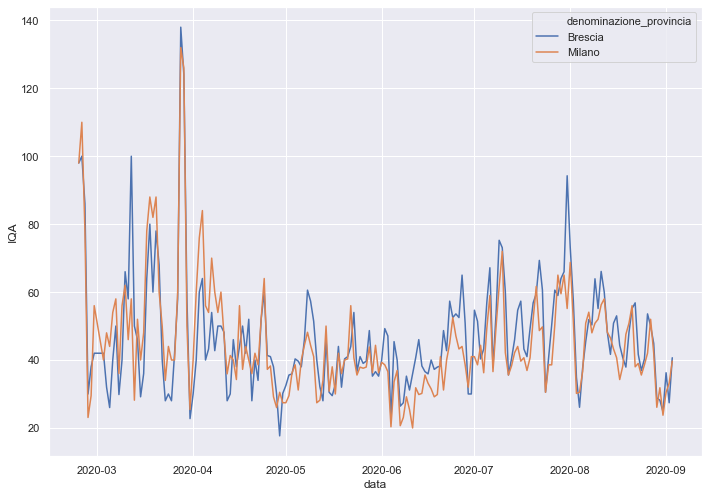

In [68]:
# plot main european cities
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
df_covid_iqa_filt = df_covid_iqa.loc[df_covid_iqa['denominazione_provincia'].isin(['Milano','Brescia'])]
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.lineplot(x="data", y="IQA", hue="denominazione_provincia",
                  data=df_covid_iqa_filt)